In [257]:
import warnings
warnings.filterwarnings("ignore")
import socket,time,math,argparse
import numpy as np
from functions import processCentroids_calib,cameraMatrix_cam1,cameraMatrix_cam2,distCoef_cam1,distCoef_cam2
from cv2 import circle,putText,imshow,waitKey,FONT_HERSHEY_SIMPLEX,destroyAllWindows,triangulatePoints,moveWindow,imwrite
from myLib import isCollinear,isEqual,swapElements,getSignal,getOrder,reshapeCoord,findNearestC,myProjectionPoints
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
import os
from myLib import estimateFundMatrix_8norm,decomposeEssentialMat


In [258]:
df1,df2 = np.genfromtxt('cam1.csv', delimiter=','),np.genfromtxt('cam2.csv', delimiter=',')
maxTime,maxFrame = max(df1[-1][-2],df2[-1][-2]),max(df1[-1][-1],df2[-1][-1])
print('Maximum captured timestamp: '+str(round(maxTime/1e6,2))+' seconds')
print('#'+str(int(maxFrame))+' frames were captured')
data = [[],[]]

Maximum captured timestamp: 117.93 seconds
#4594 frames were captured


In [259]:
def orderCenterCoord(centerCoord, prevCenterCoord, otherCamOrder = 0):
    centerX, centerY = reshapeCoord(centerCoord)
    # if it is the first image of the sequence
    if len(prevCenterCoord) == 0:  
        order,_ =  getOrder(centerX,centerY)  
        # if it is the second camera
        if otherCamOrder != 0:  
            # if the markers are wrong, swap the extremities
            signal, valid = getSignal(centerX[order[0]], centerX[order[2]],5)
            if signal != otherCamOrder and valid: order = swapElements(order, 0, 2)    
        else:        
            # get base for comparision (first camera only)        
            otherCamOrder,_ = getSignal(centerX[order[0]], centerX[order[2]])
        # sort centers        
        if np.linalg.norm(centerX[order[0]]-centerX[order[1]])>np.linalg.norm(centerX[order[2]]-centerX[order[1]]):
            sortedCenterCoord = np.array((centerCoord[order[0]], centerCoord[order[1]], centerCoord[order[2]]))
        else: sortedCenterCoord = np.array((centerCoord[order[2]], centerCoord[order[1]], centerCoord[order[0]]))
    else:
        # first reshape array of coordinates
        prevCenterX,prevCenterY = reshapeCoord(prevCenterCoord)
        # distance from marker A/B of previous img to center coordiantes of actual img
        distA = np.sqrt(np.power(np.subtract(prevCenterX[0], centerX), 2) + np.power(np.subtract(prevCenterY[0], centerY), 2))
        distB = np.sqrt(np.power(np.subtract(prevCenterX[1], centerX), 2) + np.power(np.subtract(prevCenterY[1], centerY), 2))
        # nearest marker from A is selected and removed as marker B candidate
        nearestA = np.argmin(distA)
        distBCopy = np.delete(distB, nearestA)
        # nearest marker from B is selected and removed as marker C candidate
        nearestBCopy = np.argmin(distBCopy)
        nearestB, = np.where(distB == distBCopy[nearestBCopy])
        distBCopy = np.delete(distBCopy, nearestBCopy)
        # get the missing marker position in array
        nearestC = findNearestC(nearestA, nearestB[0])
        # sort centers        
        sortedCenterCoord = [centerCoord[nearestA], centerCoord[nearestB[0]], centerCoord[nearestC]]
        # check if the ordering is ok
        centerX, centerY = reshapeCoord(sortedCenterCoord)
        prevOrder,axisPrev = getOrder(prevCenterX,prevCenterY)
        order,_ =  getOrder(centerX,centerY,baseAxis=True,axis=axisPrev)
        if (order[1] != 1) or (order[2] != prevOrder[2]):
            if prevOrder[0] == 2: order = swapElements(order,0,2) #if is decreasing, swap                
            sortedCenterCoord = np.array((sortedCenterCoord[order[0]], sortedCenterCoord[order[1]], sortedCenterCoord[order[2]]))
    return sortedCenterCoord, otherCamOrder

In [260]:
os.system('del pics\cam1\*jpg')
invalid,lastValid,tol,swap,certainty,counter,lastValid_i=0,0,0.25,0,False,0,0
intervals1,valid,jump,data[0]=[],[],[],[]
for i in range(0,df1.shape[0]):
    # get points and check invalidity sequence
    pts,imgNumb = df1[i][0:6].reshape(-1,2),int(df1[i][-1])
    if imgNumb>lastValid+1: invalid = imgNumb-lastValid
    # order markers per proximity and check collinearity
    if isCollinear(*pts) and not isEqual(pts) or np.any(pts<0):     
        if invalid>=10 or not counter: 
            if not certainty and counter: valid[-1]=False
            prev,certainty = [],False
            if counter: intervals1.extend((lastValid_i,i))
            else: intervals1.append(i)
            valid.append(True)
        else: prev = np.array(df1[lastValid_i][0:6]).reshape(1,-2)
        pts, _ = orderCenterCoord(pts,prev)
        pts = np.array(pts)
    else: 
        jump.append(imgNumb)
        invalid+=1
        continue
    # update internal loop variables
    lastValid,invalid,lastValid_i=imgNumb,0,i
    counter+=1
    df1[i][0:6] = np.copy(pts).reshape(-1,6)
    # check if ABC is in order smaller to largest
    # if 2 consecutive trues, invert all df until interval beginning
    if not certainty:
        for [A,B,C] in pts.reshape([-1, 3, 2]):
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20:
                swap += 1
                if swap>5: df1[intervals1[-1]:i][0:2],df1[intervals1[-1]:i][4:6],swap,certainty = df1[intervals1[-1]:i][4:6],df1[intervals1[-1]:i][0:2],0,True
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20: certainty = True
    #if not i%100: print(i)
intervals1.append(i)
time1=[]

for i in range(0,len(intervals1)-1,2):
    if not valid[int(i/2)]: continue
    beg,end = intervals1[i],intervals1[i+1]
    print('valid interval #'+str(int(i/2))+': indexes '+str(round(df1[beg][-2]/1e6,2))+'s to '+str(round(df1[end][-2]/1e6,2))+'s')
    time1.append([df1[beg][-2]/1e6,df1[end][-2]/1e6])
    for j in range(beg,end+1):
        pts,imgNumb,img,k = df1[j][0:6].reshape(-1,2),int(df1[j][-1]),np.ones((540,960,3))*255,0
        if imgNumb in jump: continue
        data[0].append(np.hstack((pts.reshape(-1),df1[j][-2]/1e6)))
        ### VERBOSE
        for k in range(0,3):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam1/'+str(imgNumb).zfill(4)+'.jpg',img)
print('---\nDone camera #1')
time1 = np.array(time1).reshape(-1,2)

valid interval #0: indexes 2.45s to 18.67s
valid interval #1: indexes 20.12s to 22.77s
valid interval #2: indexes 23.27s to 48.48s
valid interval #4: indexes 51.66s to 52.93s
valid interval #7: indexes 57.43s to 57.8s
valid interval #8: indexes 59.45s to 75.82s
valid interval #9: indexes 76.25s to 107.11s
---
Done camera #1


In [261]:
os.system('del pics\cam2\*jpg')
invalid,lastValid,tol,swap,certainty,counter,lastValid_i=0,0,0.25,0,False,0,0
intervals2,valid,jump,data[1]=[],[],[],[]
for i in range(0,df2.shape[0]):
    # get points and check invalidity sequence
    pts,imgNumb = df2[i][0:6].reshape(-1,2),int(df2[i][-1])
    if imgNumb>lastValid+1: invalid = imgNumb-lastValid
    # order markers per proximity and check collinearity
    if isCollinear(*pts) and not isEqual(pts) or np.any(pts<0):     
        if invalid>=10 or not counter: 
            if not certainty and counter: valid[-1]=False
            prev,certainty = [],False
            if counter: intervals2.extend((lastValid_i,i))
            else: intervals2.append(i)
            valid.append(True)
        else: prev = np.array(df2[lastValid_i][0:6]).reshape(1,-2)
        pts, _ = orderCenterCoord(pts,prev)
        pts = np.array(pts)
    else: 
        jump.append(imgNumb)
        invalid+=1
        continue
    # update internal loop variables
    lastValid,invalid,lastValid_i=imgNumb,0,i
    counter+=1
    df2[i][0:6] = np.copy(pts).reshape(-1,6)
    # check if ABC is in order smaller to largest
    # if 2 consecutive trues, invert all df until interval beginning
    if not certainty:
        for [A,B,C] in pts.reshape([-1, 3, 2]):
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20:
                swap += 1
                if swap>5: df2[intervals2[-1]:i][0:2],df2[intervals2[-1]:i][4:6],swap,certainty = df2[intervals2[-1]:i][4:6],df2[intervals2[-1]:i][0:2],0,True
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20: certainty = True
    #if not i%100: print(i)
intervals2.append(i)
time2=[]

for i in range(0,len(intervals2)-1,2):
    if not valid[int(i/2)]: continue
    beg,end = intervals2[i],intervals2[i+1]
    print('valid interval #'+str(int(i/2))+': indexes '+str(round(df2[beg][-2]/1e6,2))+'s to '+str(round(df2[end][-2]/1e6,2))+'s')
    time2.append([df2[beg][-2]/1e6,df2[end][-2]/1e6])
    for j in range(beg,end+1):
        pts,imgNumb,img,k = df2[j][0:6].reshape(-1,2),int(df2[j][-1]),np.ones((540,960,3))*255,0
        if imgNumb in jump: continue
        data[1].append(np.hstack((pts.reshape(-1),df2[j][-2]/1e6)))
        ### VERBOSE
        for k in range(0,3):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam2/'+str(imgNumb).zfill(4)+'.jpg',img)
print('---\nDone camera #2')
time2 = np.array(time2).reshape(-1,2)

valid interval #2: indexes 3.65s to 27.84s
valid interval #3: indexes 28.11s to 30.71s
valid interval #4: indexes 31.01s to 31.76s
valid interval #5: indexes 32.11s to 36.64s
valid interval #6: indexes 36.96s to 53.73s
valid interval #8: indexes 58.9s to 61.35s
valid interval #9: indexes 62.1s to 63.08s
valid interval #12: indexes 67.05s to 73.0s
valid interval #13: indexes 73.3s to 74.47s
valid interval #14: indexes 75.12s to 89.47s
valid interval #15: indexes 89.72s to 89.99s
valid interval #16: indexes 90.24s to 94.14s
valid interval #17: indexes 94.57s to 99.44s
valid interval #18: indexes 99.86s to 104.21s
valid interval #19: indexes 104.46s to 104.91s
valid interval #26: indexes 111.01s to 117.93s
---
Done camera #2


In [262]:
intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                    for first in time1 for second in time2  
                    if max(first[0], second[0]) <= min(first[1], second[1])]
print(intersections)

[[3.648676, 18.668092], [20.117552, 22.766564], [23.266378, 27.839735], [28.114624, 30.713635], [31.01355, 31.763272], [32.113149, 36.636472], [36.96135, 48.482005], [51.655825, 52.930345], [59.452917, 61.352319], [62.102039, 63.076672], [67.050208, 72.997978], [73.297888, 74.47246], [75.122213, 75.821829], [76.246673, 89.466878], [89.716819, 89.991684], [90.241615, 94.140148], [94.565016, 99.438208], [99.863051, 104.211417], [104.461349, 104.911186]]


In [263]:
valid_df1 = [row for row in data[0] for [beg,end] in intersections if beg<=row[-1]<=end]
valid_df2 = [row for row in data[1] for [beg,end] in intersections if beg<=row[-1]<=end]

In [264]:
counter=np.array([0,0]).astype(int)
step = 1/40
df = np.zeros((int(120/step),2*6+1))
df[:,-1] = np.linspace(0,120,int(120/step))
for [beg,end] in intersections:
    lastI1 = int([i for i in range(0,len(valid_df1)) if beg<=valid_df1[i][-1]<=end][-1])
    lastI2 = int([i for i in range(0,len(valid_df2)) if beg<=valid_df2[i][-1]<=end][-1])
    pts1,pts2 = valid_df1[counter[0]:lastI1+1], valid_df2[counter[1]:lastI2+1]

    # cam 1
    coord,time = np.array(pts1)[:,0:6],np.array(pts1)[:,6]
    lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
    print('interpolated #1 from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
    tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
    ff = CubicSpline(time,coord,axis=0)
    df[tNew,int(0*6):int(0*6+6)] = ff(tNew*step)

    # cam2
    coord,time = np.array(pts2)[:,0:6],np.array(pts2)[:,6]
    lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
    print('interpolated #2 from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
    tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
    ff = CubicSpline(time,coord,axis=0)
    df[tNew,int(1*6):int(1*6+6)] = ff(tNew*step)

    counter=[lastI1+1,lastI2+1]

df = np.delete(df,[i for i in range(0,df.shape[0]) if not np.any(df[i][0:6]) or not np.any(df[i][6:12])],axis = 0)
centroids1,centroids2 = df[:,0:6].reshape(-1,2),df[:,6:12].reshape(-1,2)

interpolated #1 from 3.68s to 18.65s
interpolated #2 from 3.65s to 18.62s
interpolated #1 from 20.12s to 22.75s
interpolated #2 from 20.12s to 22.73s
interpolated #1 from 23.28s to 27.83s
interpolated #2 from 23.28s to 27.83s
interpolated #1 from 28.15s to 30.7s
interpolated #2 from 28.12s to 30.7s
interpolated #1 from 31.05s to 31.75s
interpolated #2 from 31.03s to 31.75s
interpolated #1 from 32.15s to 36.62s
interpolated #2 from 32.12s to 36.62s
interpolated #1 from 37.0s to 48.48s
interpolated #2 from 36.98s to 48.45s
interpolated #1 from 51.68s to 52.93s
interpolated #2 from 51.68s to 52.9s
interpolated #1 from 59.48s to 61.35s
interpolated #2 from 59.48s to 61.35s
interpolated #1 from 62.15s to 63.08s
interpolated #2 from 62.12s to 63.08s
interpolated #1 from 67.1s to 72.98s
interpolated #2 from 67.08s to 72.98s
interpolated #1 from 73.33s to 74.45s
interpolated #2 from 73.3s to 74.45s
interpolated #1 from 75.15s to 75.8s
interpolated #2 from 75.12s to 75.78s
interpolated #1 from 

In [265]:
# get fundamental and essential matrices
F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2))
E = np.matmul(cameraMatrix_cam2.T, np.matmul(F, cameraMatrix_cam1))
print("\nEssenc. Mat.\n", E.round(4))
# decompose to rotation and translation between cameras
R, t = decomposeEssentialMat(E, cameraMatrix_cam1, cameraMatrix_cam2, np.array(centroids1), np.array(centroids2))
if np.any(np.isnan(R)): print('no valid rotation matrix')
else:
    print("\nRot. Mat.\n", R.round(4))
    print("\nTrans. Mat.\n", t.round(4))

Fund. Mat.
 [[-0.     -0.     -0.0014]
 [-0.     -0.      0.0152]
 [-0.0012 -0.0033  0.9999]]
avg x'Fx=0: 0.46943934388455616
max x'Fx=0: 2.562043700648877

Essenc. Mat.
 [[-0.4375 -6.0859 -4.4444]
 [-5.9519 -0.5156  7.4658]
 [-3.881  -6.3808 -0.1223]]

Rot. Mat.
 [[-0.0582 -0.5732  0.8174]
 [ 0.5614  0.6582  0.5016]
 [-0.8255  0.4881  0.2834]]

Trans. Mat.
 [[-0.6542 -0.3788  0.6546]]


Scale between real world and triang. point cloud is:  402.48
L_AC >> mean = 15.6864cm, std. dev = 0.1682cm, rms = 0.1687cm
L_AB >> mean = 10.1591cm, std. dev = 0.1273cm, rms = 0.1337cm
L_BC >> mean = 5.5294cm, std. dev = 0.0664cm, rms = 0.0726cm


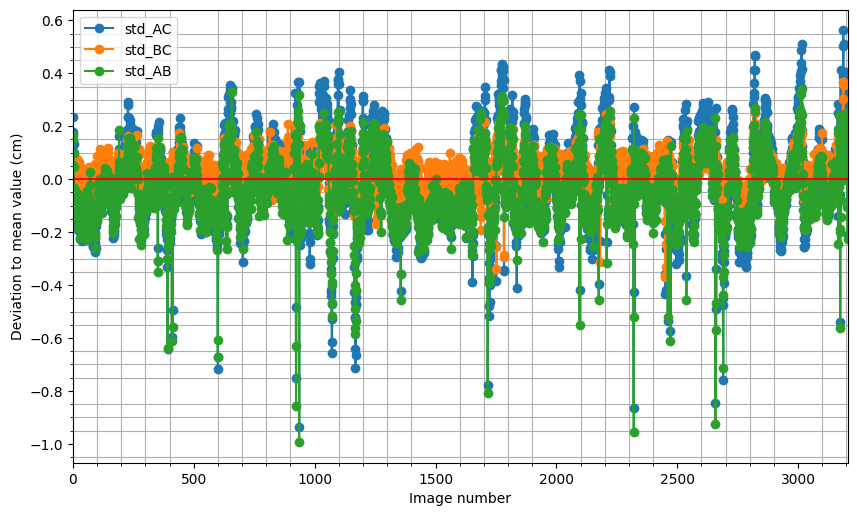

Images distant more than 1% from the real value = 1094/3208


In [267]:
P1,P2 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]])),np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k = 0,15.7,10.2,5.5,[],[],[],0
# compute sdt deviation and plot beautiful stuff
for [A, B, C] in points3d.reshape([-1, 3, 3]):
    L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
    if L_rec_AB<L_rec_BC: L_rec_AB,L_rec_BC=L_rec_BC,L_rec_AB
    if k:
        if abs(L_rec_AB*lamb-L_real_AB)>1 or abs(L_rec_AC*lamb-L_real_AC)>1 or abs(L_rec_BC*lamb-L_real_BC)>1: continue
    tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
    k = k + 3
    lamb = tot/k
    L_AC_vec.append(L_rec_AC)
    L_BC_vec.append(L_rec_BC)
    L_AB_vec.append(L_rec_AB)
print('Scale between real world and triang. point cloud is: ', lamb.round(2))
print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
fig = plt.figure(figsize=(10, 6), dpi=100)
L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
plt.plot(L_AC_vec_plot, '-o', label="std_AC")
plt.plot(L_BC_vec_plot, '-o', label="std_BC")
plt.plot(L_AB_vec_plot, '-o', label="std_AB")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("Image number")
plt.ylabel("Deviation to mean value (cm)")
plt.legend()
ax = fig.axes
ax[0].minorticks_on()
plt.grid(which='both')
plt.xlim(0,len(L_AC_vec)-1)
plt.draw()
plt.show()
points3d_new,i= points3d*lamb,0
for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
    L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
    valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
    if not valid: i = i + 1
print("Images distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))